# Import

In [1]:
from model import ChessNet
import torch
import torch.nn as nn
from torchsummary import summary
import pandas as pd
from utils import read_pgn
import chess
from IPython.display import display, clear_output
from time import sleep
from torch.utils.data import DataLoader, Dataset
from typing import List, Tuple
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle
import os
import gc

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preprocessing

In [3]:
df1 = pd.read_csv("../games_metadata_profile.csv")
df2 = pd.read_csv("../games_metadata_profile_2024_01.csv")


def format_game_mode(x):
    if "Classical" in x:
        return "Classical game"
    elif "Bullet" in x:
        return "Bullet game"
    elif "Blitz" in x:
        return "Blitz game"
    elif "UltraBullet" in x:
        return "UltraBullet game"
    elif "Rapid" in x:
        return "Rapid game"
    elif "Correspondence" in x:
        return "Correspondence game"
    else:
        return x


df = pd.concat([df1, df2], ignore_index=True)

df["Mode"] = df["Event"].apply(format_game_mode)

df = df[df["Mode"] == "Blitz game"]

In [4]:
df_elo_below_1450 = df[(df["WhiteElo"] + df["BlackElo"]) / 2 <= 1450]
df_elo_1450_to_1800 = df[
    ((df["WhiteElo"] + df["BlackElo"]) / 2 > 1450)
    & ((df["WhiteElo"] + df["BlackElo"]) / 2 <= 1800)
]
df_elo_above_1800 = df[(df["WhiteElo"] + df["BlackElo"]) / 2 > 1800]

print(f"# games with average elo below 1450: {df_elo_below_1450.shape}")

print(f"# games with average elo between 1450 and 1800: {df_elo_1450_to_1800.shape}")

print(f"# games with average elo above 1800: {df_elo_above_1800.shape}")

del df1, df2, df
gc.collect()

# games with average elo below 1450: (30057, 34)
# games with average elo between 1450 and 1800: (32038, 34)
# games with average elo above 1800: (31863, 34)


0

In [5]:
cutoff = 15000  # number of games to use for each partition

df_elo_below_1450 = df_elo_below_1450.sample(cutoff)

df_elo_1450_to_1800 = df_elo_1450_to_1800.sample(cutoff)

df_elo_above_1800 = df_elo_above_1800.sample(cutoff)

print(f"# games with average elo below 1450: {df_elo_below_1450.shape}")

print(f"# games with average elo between 1450 and 1800: {df_elo_1450_to_1800.shape}")

print(f"# games with average elo above 1800: {df_elo_above_1800.shape}")

# games with average elo below 1450: (15000, 34)
# games with average elo between 1450 and 1800: (15000, 34)
# games with average elo above 1800: (15000, 34)


In [6]:
# move ==> (_from, _to, board)
# board ==> 8x8 numpy array
def process_game(moves: List[chess.Move]):
    board = chess.Board()
    samples = []
    for move in moves:
        _from, _to = move.from_square, move.to_square
        # from square index to algebraic notation
        piece = board.piece_at(_from)
        _from, _to = chess.SQUARE_NAMES[_from], chess.SQUARE_NAMES[_to]
        samples.append((str(_from), str(_to), str(piece), board.fen()))
        board.push(move)

    return samples

In [65]:
def pgns_to_samples(
    game_pgns: List[str] = None,
    save_dir: str = None,
    suffix: str = "",
    write_to_disk: bool = True,
):
    assert (
        game_pgns is not None or save_dir is not None
    ), "game_pgns OR save_dir must be provided"

    is_train_saved = False
    is_test_saved = False
    train_samples = []
    test_samples = []
    if save_dir:
        if f"train_{suffix}.pkl" in os.listdir(save_dir):
            print("Loading train samples from disk")
            is_train_saved = True
            with open(f"{save_dir}/train_{suffix}.pkl", "rb") as f:
                train_samples = pickle.load(f)

        if f"test_{suffix}.pkl" in os.listdir(save_dir):
            print("Loading test samples from disk")
            is_test_saved = True
            with open(f"{save_dir}/test_{suffix}.pkl", "rb") as f:
                test_samples = pickle.load(f)

    if game_pgns is not None:
        train_pgn, test_pgn = train_test_split(
            game_pgns, test_size=0.2, random_state=42
        )

        if not is_train_saved:
            print("Processing train samples")
            for game_pgn in tqdm(train_pgn):
                game_moves = read_pgn(game_pgn)
                train_samples.extend(process_game(game_moves))
            if write_to_disk:
                with open(f"{save_dir}/train_{suffix}.pkl", "wb") as f:
                    pickle.dump(train_samples, f)
                    print(f"Train samples saved to {save_dir}/train_{suffix}.pkl")

        if not is_test_saved:
            print("Processing test samples")
            for game_pgn in tqdm(test_pgn):
                game_moves = read_pgn(game_pgn)
                test_samples.extend(process_game(game_moves))
            if write_to_disk:
                with open(f"{save_dir}/test_{suffix}.pkl", "wb") as f:
                    pickle.dump(test_samples, f)
                    print(f"Test samples saved to {save_dir}/test_{suffix}.pkl")
    # remove duplicates
    train_samples = list(set(train_samples))
    test_samples = list(set(test_samples))
    return train_samples, test_samples

In [8]:
game_below_1450 = df_elo_below_1450["Moves"].values
game_1450_to_1800 = df_elo_1450_to_1800["Moves"].values
game_above_1800 = df_elo_above_1800["Moves"].values

In [66]:
train_below_1450, test_below_1450 = pgns_to_samples(
    save_dir="data",
    suffix="below_1450_15kCUTOFF",
    # write_to_disk=False,
    # game_pgns=game_below_1450
)
train_1450_to_1800, test_1450_to_1800 = pgns_to_samples(
    save_dir="data",
    suffix="1450_to_1800_15kCUTOOF",
    # write_to_disk=False,
    # game_pgns=game_1450_to_1800
)
train_above_1800, test_above_1800 = pgns_to_samples(
    save_dir="data",
    suffix="above_1800_15kCUTOFF",
    # write_to_disk=False,
    # game_pgns=game_above_1800
)

Loading train samples from disk
Loading test samples from disk
Loading train samples from disk
Loading test samples from disk
Loading train samples from disk
Loading test samples from disk


In [68]:
print(f"# train samples below 1450: {len(train_below_1450)}")
print(f"# train samples between 1450 and 1800: {len(train_1450_to_1800)}")
print(f"# train samples above 1800: {len(train_above_1800)}")

# train samples below 1450: 663358
# train samples between 1450 and 1800: 713766
# train samples above 1800: 779151


In [11]:
# encode board into 6 channel tensor
# each channel represents a different type of piece
# 0: empty square
# 1: white pieces, 2: black pieces
# 1st channel: pawns, 2nd channel: knights, 3rd channel: bishops
# 4th channel: rooks, 5th channel: queens, 6th channel: kings
def transform_board(board, mask_loc: str = None) -> torch.Tensor:
    piece_map = {
        "p": 1,
        "n": 2,
        "b": 3,
        "r": 4,
        "q": 5,
        "k": 6,
    }
    board_tensor = torch.zeros(6, 8, 8)
    for i in range(8):
        for j in range(8):
            piece = board.piece_at(chess.square(i, j))
            if piece is not None:
                color = 1 if piece.color == chess.WHITE else -1
                piece_symbol = piece.symbol().lower()
                board_tensor[piece_map[piece_symbol] - 1, i, j] = color

    if mask_loc is not None:  # add new channels of mask to the board tensor
        mask_tensor = torch.zeros(1, 8, 8)
        # convert mask_loc san to square index
        mask_square = chess.parse_square(mask_loc)
        piece = board.piece_at(mask_square)
        if piece is None:
            raise ValueError(f"no piece at mask square {mask_loc}")
        mask_tensor[0, mask_square % 8, mask_square // 8] = (
            1 if piece.color == chess.WHITE else -1
        )
        board_tensor = torch.cat((board_tensor, mask_tensor), dim=0)

    return board_tensor

In [12]:
# group samples with the same board state, produce a probability distribution of moves
# sample ==> {board: {
#   piece: count
# }}


def group_board(samples):
    board_grouped = {}

    # count the number of moves for each piece in each board state
    for sample in samples:
        _from, _to, piece, board_fen = sample
        board_position = board_fen.split(" ")[0]

        if board_position not in board_grouped:

            board_grouped[board_position] = {"total": 0}


        for idx, subkey in enumerate(
            [
                _from
                #   , _to
            ]
        ):
            # if idx == 0: # specicial prefix to denote from or to
            #     subkey = f"f{subkey}"
            # else:
            #     subkey = f"t{subkey}"
            if subkey not in board_grouped[board_position]:
                board_grouped[board_position][subkey] = 0
            board_grouped[board_position][subkey] += 1


        board_grouped[board_position]["total"] += 1

    # convert the count to probability distribution
    for board_position in board_grouped:

        total = board_grouped[board_position]["total"]

        for subkey in board_grouped[board_position]:
            if subkey == "total":
                continue
            board_grouped[board_position][subkey] /= total

        del board_grouped[board_position]["total"]

    # dict to list

    board_grouped = list(board_grouped.items())
    return board_grouped

In [13]:
# transform piece distribution to tensor label
# piece_distribution = {'e1': 0.5, 'd2': 0.2, ...}
# piece_distribution ==> tensor(64)
def piece_distribution_to_label(piece_distribution):
    label = torch.zeros(64)

    for i, piece in enumerate(piece_distribution):
        idx = chess.parse_square(piece)
        label[idx] = piece_distribution[piece]

    return label

In [14]:
def filter_by_piece(samples: List[Tuple[str, str, str, str]], piece: str):
    return list(filter(lambda x: x[2].lower() == piece, samples))

# Dataset

In [15]:
class ChessGroupedDataset(Dataset):
    def __init__(self, grouped_moves: List[Tuple[str, dict]]):
        self.grouped_moves = grouped_moves

    def __len__(self):
        return len(self.grouped_moves)

    def __getitem__(self, idx):
        board_fen, piece_probs = self.grouped_moves[idx]
        board = chess.Board(board_fen)
        # feature is the board tensor
        x = transform_board(board)
        # label is one-hot encoded _from
        y = piece_distribution_to_label(piece_probs)
        # if play side is black, flip the board both two ways and the label
        if board.turn == chess.BLACK:
            x = x.flip(1).flip(2)
            y = y.flip(0)

        return x, y

In [40]:
class ChessDataset(Dataset):
    def __init__(self, moves: List[Tuple[str, str, str, str]], mask_move: bool = False):
        self.moves = moves  # (from, to, piece, board_fen)
        self.mask_move = mask_move

    def __len__(self):
        return len(self.moves)

    def __getitem__(self, idx):
        _from, _to, piece, board_fen = self.moves[idx]
        board = chess.Board(board_fen)
        x = (
            transform_board(board)
            if not self.mask_move
            else transform_board(board, mask_loc=_from)
        )
        # label is one-hot encoded _from
        y = torch.zeros(64)
        # convert _to name to index, igoring promotion(last letter)
        _to = chess.parse_square(_to[:2])
        y[_to] = 1
        # if play side is black, flip the board both two ways and the label
        if board.turn == chess.BLACK:
            x = x.flip(1).flip(2)
            y = y.flip(0)

        return x, y

# Training

In [55]:
def training(model, dataloader, criterion, optimizer, num_epochs=10):
    model.train()
    train_loss = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(dataloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 100 == 99:
                print(
                    f"epoch {epoch+1}/{num_epochs} | batch {i+1} | loss: {running_loss / 100}"
                )
                train_loss.append(running_loss / 100)
                running_loss = 0.0
        clear_output(wait=True)
    return train_loss

# Training piece selection

## Model + training

In [ ]:
model = ChessNet(
    num_classes=64,
    num_channels=6,
    activation=nn.LeakyReLU(inplace=True),
).to(device)

In [ ]:
# load model
# model.load_state_dict(torch.load("piece_grouped_sel_ce_20epc.pth"))

In [ ]:
# summary(model, (6, 8, 8), batch_size=1)

In [ ]:
grouped_train_samples = group_board(train_below_1450)
grouped_test_samples = group_board(test_below_1450)

len(grouped_train_samples), len(grouped_test_samples)

(159228, 40500)

In [ ]:
piece_sel_ds = ChessGroupedDataset(grouped_train_samples)
piece_sel_dl = DataLoader(piece_sel_ds, batch_size=64, shuffle=True)

# sample from the dataset
x, y = piece_sel_ds[0]

x.shape, y.shape, len(piece_sel_ds)

(torch.Size([6, 8, 8]), torch.Size([64]), 159228)

In [19]:
EPOCHS = 10
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_history = training(model, piece_sel_dl, criterion, optimizer, num_epochs=EPOCHS)

Epoch 10/10
----------
batch 0 loss: 4.106743812561035
batch 200 loss: 4.054723739624023
batch 400 loss: 4.028746128082275
batch 600 loss: 4.072626113891602
batch 800 loss: 4.060213088989258
batch 1000 loss: 4.090933322906494
batch 1200 loss: 4.06001091003418
batch 1400 loss: 4.10654354095459
batch 1600 loss: 4.091612815856934
batch 1800 loss: 4.138007164001465
batch 2000 loss: 4.028840065002441
batch 2200 loss: 4.063558578491211
batch 2400 loss: 4.138141632080078
__Epoch loss: 4.079843078491389


In [20]:
# save the model
torch.save(model.state_dict(), "grouped_ce_10epc_lrelu_0.01.pth")

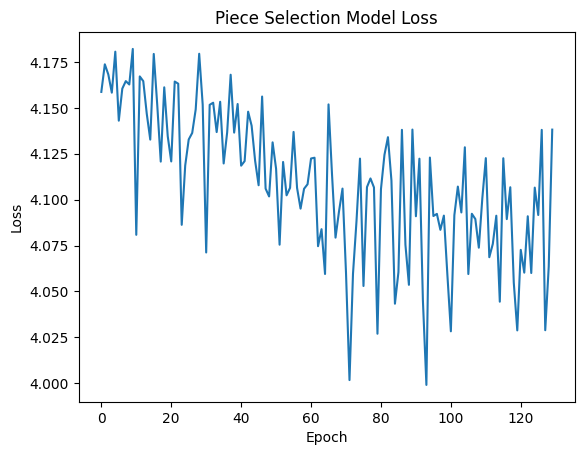

In [21]:
# plot loss history
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Piece Selection Model Loss")
plt.show()

## Evaluation

In [88]:
test_samples_ds = ChessDataset(test_above_1800)
test_samples_dl = DataLoader(test_samples_ds, batch_size=64, shuffle=False)

test_piece_sel_ds = ChessGroupedDataset(grouped_test_samples)
test_piece_sel_dl = DataLoader(test_piece_sel_ds, batch_size=64, shuffle=False)

In [89]:
# evaluate KL divergence between the predicted distribution and the true distribution
# KL divergence is a measure of how one probability distribution diverges from a second, expected probability distribution
# KL divergence is 0 if the two distributions are identical
model.eval()
kl_divergence = 0.0
for idx, (x, y) in enumerate(test_piece_sel_dl):
    x, y = x.to(device), y.to(device)
    output = model(x)
    kl_divergence += nn.KLDivLoss()(output, y).item()

kl_divergence /= len(test_piece_sel_dl)
print(f"KL Divergence: {kl_divergence}")

c:\Users\Hoang\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\functional.py:2943: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


KL Divergence: 0.0019808672005763076


In [46]:
# get the move from argmax of the predicted distribution
def argmax_move(batch: torch.Tensor):
    argmax_idx = torch.argmax(batch, dim=1)
    pred_y = torch.zeros_like(batch)
    pred_y[torch.arange(batch.shape[0]), argmax_idx] = 1

    return pred_y.to(device)

In [91]:
model.eval()
total = 0
correct = 0
for idx, (x, y) in enumerate(test_samples_dl):
    x, y = x.to(device), y.to(device)
    output = model(x)
    output = torch.softmax(output, dim=1)
    pred_y = argmax_move(output)
    correct += (pred_y == y).all(dim=1).sum().item()
    total += y.size(0)

print(f"Accuracy argmax move: {(correct/total) * 100:.3f}%")

Accuracy: 20.174%


# Training move selection

## Model + training

In [69]:
piece_type = ["p", "n", "b", "r", "q", "k"]  # pawn, knight, bishop, rook, queen, king

In [70]:
src_sample = train_above_1800
move_sel_sample = {piece: filter_by_piece(src_sample, piece) for piece in piece_type}

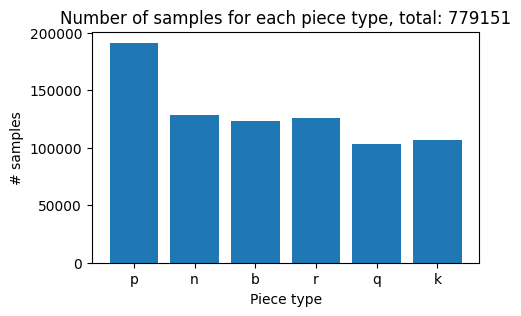

In [72]:
# plot the size of each piece type
plt.figure(figsize=(5, 3))
plt.bar(
    range(len(move_sel_sample)), [len(move_sel_sample[piece]) for piece in piece_type]
)
plt.xticks(range(len(move_sel_sample)), piece_type)
plt.xlabel("Piece type")
plt.ylabel("# samples")
plt.title(f"Number of samples for each piece type, total: {len(src_sample)}")
plt.show()

## Training on single piece


In [91]:
piece = "b" # bishop

In [92]:
model = ChessNet(
    num_classes=64,
    num_channels=7,
    activation=nn.LeakyReLU(inplace=True, negative_slope=0.05),
).to(device)

In [93]:
samples = filter_by_piece(src_sample, piece)
ds = ChessDataset(samples, mask_move=True)
dl = torch.utils.data.DataLoader(ds, batch_size=128, shuffle=True)

# sample from the dataset
x, y = ds[0]
x.shape, y.shape, len(ds)

(torch.Size([7, 8, 8]), torch.Size([64]), 123555)

In [94]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_history = training(model, dl, criterion, optimizer, num_epochs=10)

epoch 7/10 | batch 100 | loss: 1.1278330564498902
epoch 7/10 | batch 200 | loss: 1.1197992688417435
epoch 7/10 | batch 300 | loss: 1.151699143052101
epoch 7/10 | batch 400 | loss: 1.134319497346878
epoch 7/10 | batch 500 | loss: 1.160459423661232


## Evaluation

In [ ]:
# save the model
torch.save(model.state_dict(), f"move_{piece}_leakyrelu0.05_epc10_batsize128.pth")

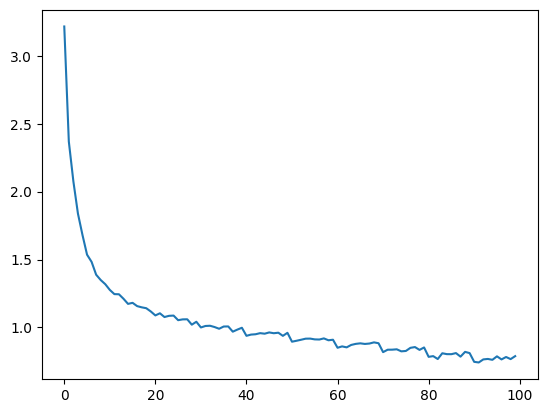

In [ ]:
# plot loss history
plt.plot(loss_history)

In [ ]:
test_samples = filter_by_piece(test_above_1800, piece)

test_ds = ChessDataset(test_samples, mask_move=True)
test_dl = DataLoader(test_ds, batch_size=128, shuffle=False)

In [ ]:
model.eval()
total = 0
correct = 0

for idx, (x, y) in enumerate(tqdm(test_dl)):
    x, y = x.to(device), y.to(device)
    output = model(x)
    output = torch.softmax(output, dim=1)
    pred_y = argmax_move(output)
    correct += (pred_y == y).all(dim=1).sum().item()
    total += y.size(0)

print(f"Accuracy argmax move: {(correct/total) * 100:.3f}%")

100%|██████████| 263/263 [00:18<00:00, 14.61it/s]

Accuracy argmax move: 73.001%


# Results

Piece selection(70 epochs, batch size 256)

43% accuracy

Move selection(10 epochs, batch size 128)
* Pawn: 89% accuracy
* Knight: 73% accuracy
* Queen: 89% accuracy
* Bishop: 
* Rook:
* King:
